<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/04_predictive_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Let's import some much needed libraries...**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
import xlrd
print('done!')

done!


In [3]:
# Let's get all the colors available in matplotlib
other_colors = []
darker_colors = []
for name, hex in mpl.colors.cnames.items():
    if 'dark' in name:
        darker_colors.append(name)
    else:
        other_colors.append(name)

# Let's finally save the various plot styles in matplotlib
styles = plt.style.available

print(f'darker-colors has {len(darker_colors)},\nother-colors has {len(other_colors)} colors\nplotting styles are {len(styles)}')

darker-colors has 19,
other-colors has 129 colors
plotting styles are 26


In [4]:
# set more matplotlib defaults
def set_rcParams():
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['text.color'] = 'k'
    mpl.rc('lines', linewidth=4, linestyle='-.')
    print('rcParams set!')

# Set the plots design to xkcd
# plt.xkcd()  # For xkcd style plots
#plt.rcdefaults()  # to stop xkcd plots

# fontdict for plot titles
fontDict1 = {'fontfamily': 'fantasy',
             'fontsize': 'x-large',
             'fontstyle': 'italic',
             'fontweight': 'heavy',
             'ha': 'center',
             'color': 'darkred',
             'va': 'baseline'}

# fontdict for plot labels
fontDict2 = {'fontfamily': 'serif',
             'fontsize': 'large',
             'fontstyle': 'oblique',
             'fontweight': 'semibold',
             'ha': 'center',
             'color': 'black',
             'va': 'baseline'}

set_rcParams()

rcParams set!


**Let's change our Directory to the Fraud directory containing our data**

In [5]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [6]:
# Let's see the contents of the CWD
os.listdir()

['Fraud_sample_data.xlsx',
 'questionsAndPoints.gdoc',
 '.ipynb_checkpoints',
 '01_intro_to_fraud_analysis.ipynb',
 '05_prescriptive_analytics.ipynb',
 'fraud_analysis.ipynb',
 'july_df.csv',
 'june_df.csv',
 'data_dict.csv',
 '02_descriptive_analytics.ipynb',
 'combined_df.csv',
 'mi_combined.csv',
 'top_five_clusters.csv',
 'top_fraud_cluster.csv',
 '04_predictive_analytics.ipynb',
 'processed_mi_combined.csv',
 '03_diagnostic_analytics.ipynb']

### 1. Loading previous data from Diagnostic stage..

In [7]:
# First, we load the data dictionary...

pd.set_option('max_colwidth', None)
data_dict  = pd.read_csv('data_dict.csv')
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


In [8]:
# Next, we load combined_df, the original unprocessed June & July data.

combined_df = pd.read_csv('combined_df.csv')
print(f'shape of combined_df; {combined_df.shape}\n')
combined_df.head(3)

shape of combined_df; (17418, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1


# Predictive EDA (PA1): 

**Predictive Analytics (PA1):**<br>
Predictive analytics is the branch of the advanced analytics which is 
used to make predictions about unknown future events.

Predictive analytics uses many techniques from **datamining**, **statistics**, 
**modelling**, **machine learning**, and **artificial intelligence** to analyse
current data to make predictions about the future.

In this case, we shall attempt to build a **time-series forecasting model**, that can forecast the fraud-count trend and fraud-volume-usd losses, if this spike continues. This will help Paystack management to see the likely effect of the current fraud spike in the near future. 

The questions we will attempt to answer in this notebook include...

1. How can we train a model to near-accurately predict the present fraud trend?
2. How can we use that model to predict future fraud trends for the near future?
3. How can we predict the financial impact of the current spike in fraud for the next few months?
4. How much do our merchants stand to lose if this continues?

In [9]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)
from fbprophet import Prophet

Prophet 0.7.1


### 2. Preparing and Visualizing Time-Series data

Here, we shall load the fraud_count data and prepare it in the right way for univariate time-series-forecasting

In [10]:
time_df_fraud = combined_df.groupby(['transaction_week_start_date'])['fraud_count'].sum().to_frame()
time_df_fraud.reset_index(inplace=True)
time_df_fraud

,transaction_week_start_date,fraud_count
0,2021-06-07,256
1,2021-06-14,284
2,2021-06-21,182
3,2021-06-28,211
4,2021-07-05,112
5,2021-07-12,109
6,2021-07-19,70
7,2021-07-26,100


**Let's confirm we have the right data types, `datetime` and `int`**.

In [11]:
time_df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   transaction_week_start_date  8 non-null      object
 1   fraud_count                  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


`transaction_week_start_date` is an object-type, let's change it to datatime

In [12]:
time_df_fraud.transaction_week_start_date = pd.to_datetime(time_df_fraud['transaction_week_start_date'])

# let's confirm the change
time_df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   transaction_week_start_date  8 non-null      datetime64[ns]
 1   fraud_count                  8 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 256.0 bytes


**Visualizing the time-series-data**

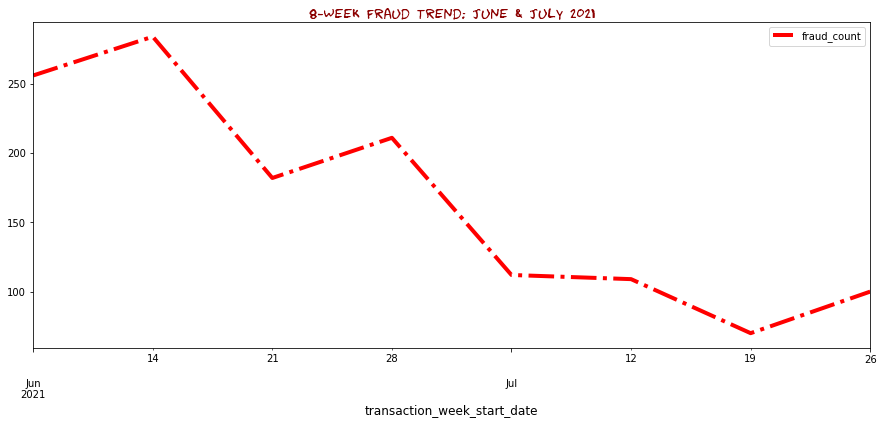

In [13]:
y = time_df_fraud.copy(deep=True)
y = y.set_index('transaction_week_start_date')
y.plot(figsize=(15,6), color='red')
plt.title('8-Week Fraud Trend: June & July 2021', fontdict=fontDict1)
plt.show()

The time-series for fraud-count has a general downward trend. Let's apply some more detailed visualization.

### 3. Applying The facebook Prophet model

Ideally, time-series is a lot better with more historical data. Sadly, we only have weekly data for 2 months, June and July. Therefore we would use the FBProphet model, whicj=h is a very robust time-series model. At the core, it's an additive regression based model.

The Prophet model requires the datetime column to be named `ds` and the forecasting column to be name `y`.

In [14]:
time_df_fraud.columns = ['ds', 'y']
time_df_fraud

,ds,y
0,2021-06-07,256
1,2021-06-14,284
2,2021-06-21,182
3,2021-06-28,211
4,2021-07-05,112
5,2021-07-12,109
6,2021-07-19,70
7,2021-07-26,100


In [15]:
def fit_model(df):
    """Fit a FB Prophet model
        to time-series data
        for forecasting
    
    @param df: a dataframe with columns ds and y
    """
    # Assert df has columns ds and y
    assert 'ds' and 'y' in df.columns, 'columns ds and y must be present'

    model = Prophet()
    model.fit(df)

    return model

In [16]:
model = fit_model(time_df_fraud)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


### 4. Making in-sample predictions:

Let's see how the model performs on data that it has seen before. By this, I mean present fraud trend data

In [17]:
# First, drop the y column
target = time_df_fraud.pop('y')

# Next make a prediction
pred_insample = model.predict(time_df_fraud)

**Let's see a display of some of the model predictions**

In [18]:
pred_insample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-06-07,268.263275,229.650896,307.238686
1,2021-06-14,238.853898,199.124227,277.727383
2,2021-06-21,209.444521,169.743325,250.989110
3,2021-06-28,180.035144,141.491106,218.965262
4,2021-07-05,150.625767,112.596746,190.673326
5,2021-07-12,121.216390,83.192787,161.690291
6,2021-07-19,91.807013,50.776092,127.749214
7,2021-07-26,62.397636,24.032180,104.106002


In [19]:
def pred_plot(predictions, target=None, title=None):
    """Method to plot upper, lower bounds
        and actual time-series predictions

    @param predictions: A dataframe of FBProphet predictions
    @param target: A series object of terget variable if available
    """
    pred = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
    if target is not None:
        pred['target'] = list(target)

    mpl.style.use('seaborn-white')
    pred.plot(figsize=(15,6), color=random.sample(darker_colors, pred.shape[1]))
    plt.title(title, fontdict=fontDict1)
    plt.grid()
    plt.show()

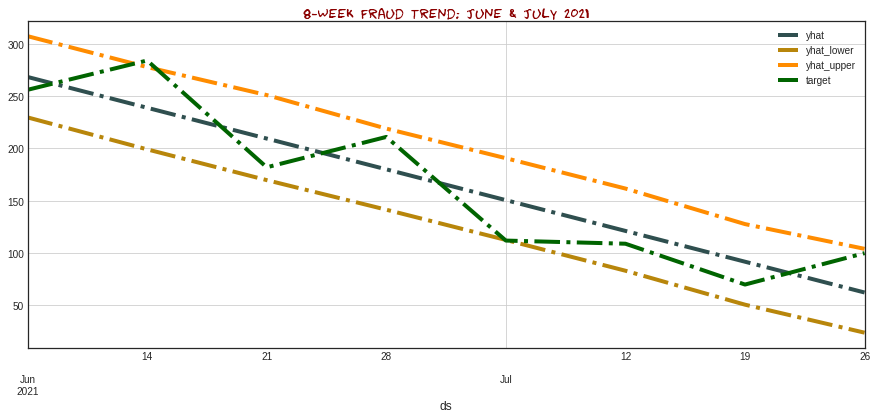

In [20]:
title = '8-Week Fraud Trend: June & July 2021'
pred_plot(pred_insample, target=target, title=title)

In [21]:
week_names = ['Jun_W'+str(i) if i < 5 else 'Jul_W'+str(i-4) for i in range(1, len(y)+1)]

We can see how FB Prophet performs very well on the training data. It's `yhat_lower` and `yhat_upper`, aptly cover the lower bounds and upper bounds of the real fraud trend. While `yhat` is in an average position between these two bounds. We can also see the zig-zagged trend of the target or real fraud-trend too.

Let's plot it using prophet

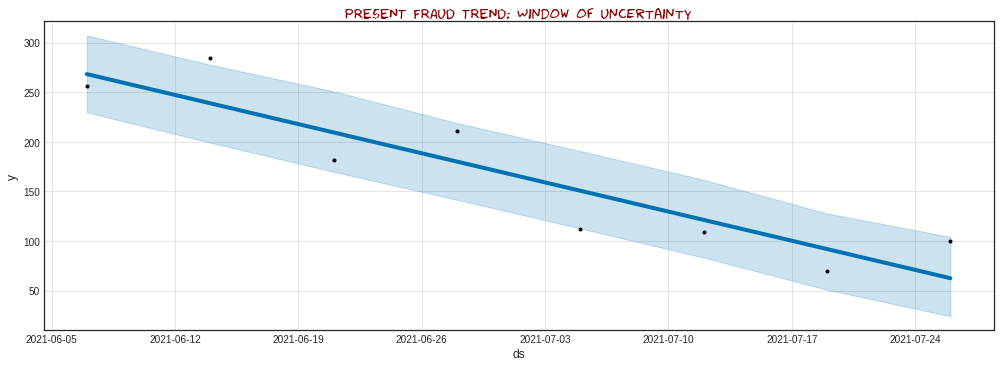

In [22]:
fig1 = model.plot(pred_insample, figsize=(14, 5))
plt.title('PRESENT FRAUD TREND: Window of Uncertainty', fontdict=fontDict1)
plt.show()

From the above plot, we can see the thick blue line of our model prediction and the lighter blue shade around it denoting the upper and lower bounds window of uncertainty or range of possible values.

We can see forecast components by...

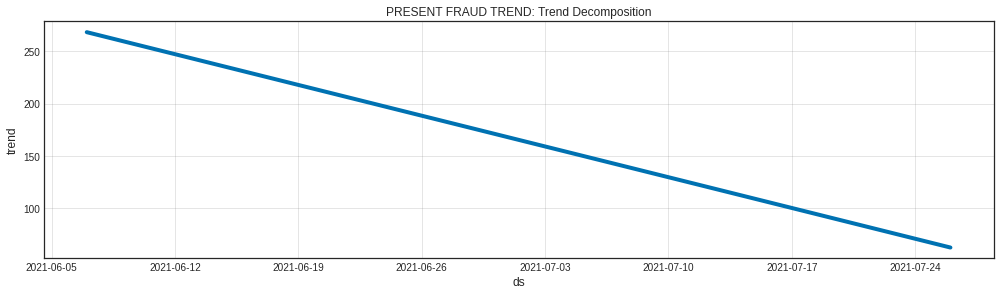

In [23]:
fig2 = model.plot_components(pred_insample, figsize=(14,4))
plt.title('PRESENT FRAUD TREND: Trend Decomposition')
plt.show()

### 5. Making out-of-sample predictions:

Let's see how the model performs on data that it has never seen before. By this, I mean the future data. Data fro the next few weeks or months.

This is our goal really, to predict future impact of fraud if the right measures are not deployed immediately.

Since we only have 2 months worth of training data, we should not try to forecast more than 2 or 3 months. Because generally, even for models trained with enough historical data, the window of uncertainty tends to expand as time goes on. So let's limit forecasts to within 90 days.

In [24]:
future_sixtyDays = model.make_future_dataframe(periods=60)
future_sixtyDays.tail()

,ds
63,2021-09-20
64,2021-09-21
65,2021-09-22
66,2021-09-23
67,2021-09-24


So we have a dataframe of dates from `7th June 2021` to `24th Sept 2021`.

Let's make an out-of-sample prediction

In [25]:
pred_outsample = model.predict(future_sixtyDays)
pred_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-06-07,268.263275,226.335520,307.416248
1,2021-06-14,238.853898,203.470099,280.400538
2,2021-06-21,209.444521,172.190897,251.436841
3,2021-06-28,180.035144,138.745868,220.718450
4,2021-07-05,150.625767,110.310440,186.822929


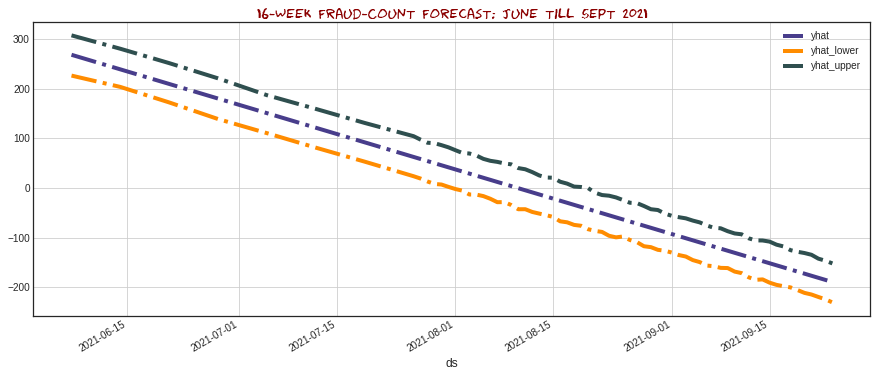

In [26]:
title = '16-Week Fraud-Count Forecast: June till Sept 2021'
pred_plot(pred_outsample, title=title)

With the largely downward trend of fraud-count from June till July, it is no surprise that FB Prophet also captures this trend aptly. 

Therefore the Prophet model captures that by `15th August 2021` fraud count will be zero if this current trend continues.

My job as a fraud Analyst is to see how we can work together to stop fraud immediately.

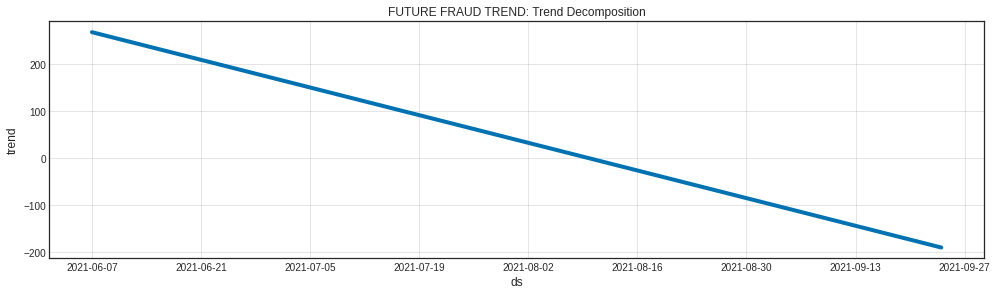

In [27]:
fig3 = model.plot_components(pred_outsample, figsize=(14,4))
plt.title('FUTURE FRAUD TREND: Trend Decomposition')
plt.show()

### 5. Predicting Fraud Losses in USD:

This is our goal really, to predict future impact of fraud if the right measures are not deployed immediately.

Since we only have 2 months worth of training data, let's forecast fraud losses for the next 2 months

In [28]:
# Structuring the Time-Series Data

time_df_loss = combined_df.groupby(['transaction_week_start_date'])['fraud_volume_usd'].sum().to_frame()
time_df_loss.reset_index(inplace=True)
time_df_loss

,transaction_week_start_date,fraud_volume_usd
0,2021-06-07,22159.797559
1,2021-06-14,36833.688766
2,2021-06-21,25996.348766
3,2021-06-28,28377.045984
4,2021-07-05,15521.942257
5,2021-07-12,16514.903596
6,2021-07-19,17782.109738
7,2021-07-26,14512.418478


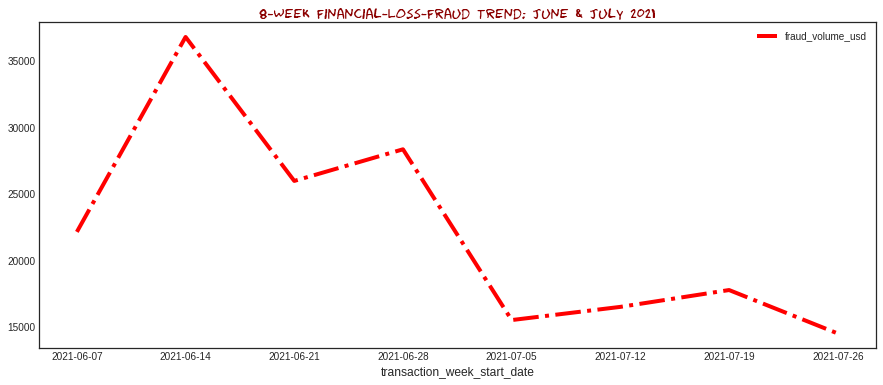

In [29]:
# visualizing the data

y = time_df_loss.copy(deep=True)
y = y.set_index('transaction_week_start_date')
y.plot(figsize=(15,6), color='red')
plt.title('8-Week Financial-Loss-Fraud Trend: June & July 2021', fontdict=fontDict1)
plt.show()

In [30]:
# rename the columns

time_df_loss.columns = ['ds', 'y']
time_df_loss.head()

,ds,y
0,2021-06-07,22159.797559
1,2021-06-14,36833.688766
2,2021-06-21,25996.348766
3,2021-06-28,28377.045984
4,2021-07-05,15521.942257


In [31]:
# fit the model

model = fit_model(time_df_loss)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


In [32]:
# make out-of-sample future predictions

pred_outsample2 = model.predict(future_sixtyDays)
pred_outsample2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-06-07,30031.923273,23826.946122,36960.256659
1,2021-06-14,27792.547004,21478.587644,34115.035654
2,2021-06-21,25553.170739,19239.077992,32363.853542
3,2021-06-28,23313.794472,16994.454789,29957.040914
4,2021-07-05,21074.418201,14344.937905,27341.412846


let's round all figures to 2 D.P

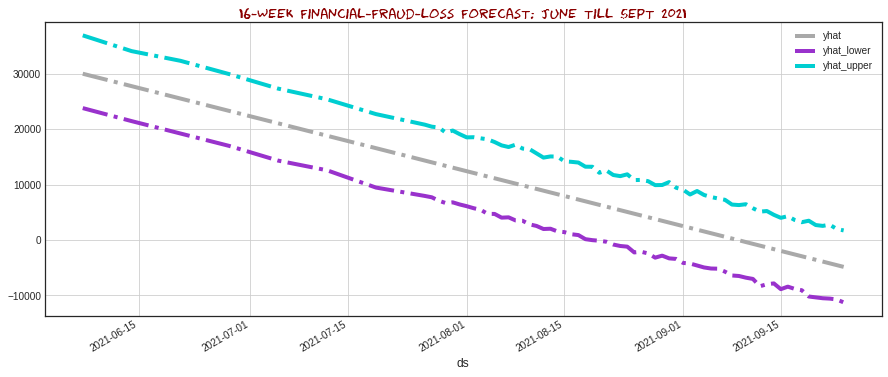

In [33]:
title = '16-Week Financial-Fraud-loss Forecast: June till Sept 2021'
pred_plot(pred_outsample2, title=title)

The training data ends on 26th July 2021. 

Therefore the Prophet model captures that fraud losses could be on till `15th Sept 2021` going by the current trend.

My job as a fraud Analyst is to see how we can work together to stop fraud losses immediately.

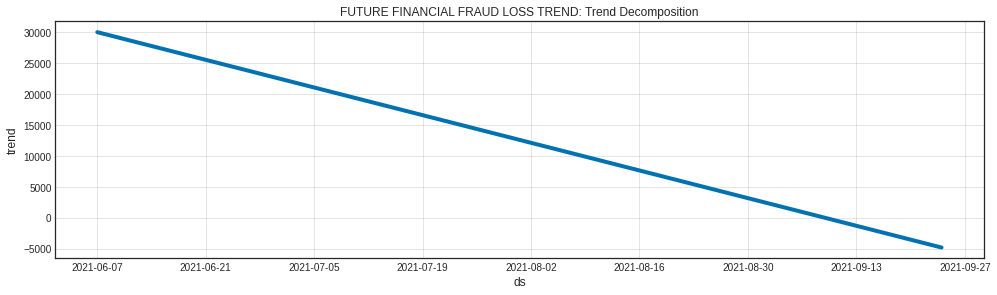

In [34]:
fig4 = model.plot_components(pred_outsample2, figsize=(14,4))
plt.title('FUTURE FINANCIAL FRAUD LOSS TREND: Trend Decomposition')
plt.show()

In [35]:
start_ind = pred_outsample2[pred_outsample2.ds == '2021-07-27'].index.values[0]
stop_ind = pred_outsample2[pred_outsample2.ds == '2021-09-13'].index.values[0]
print(f'start index: {start_ind}\nstop index: {stop_ind}')

start index: 8
stop index: 56


In [36]:
pred_loss_window = pred_outsample2.loc[start_ind : stop_ind]
pred_loss_window.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8,2021-07-27,14036.378496,7723.953510,20474.042584,14036.378496,14036.378496,0.0,0.0,0.0,0.0,0.0,0.0,14036.378496
9,2021-07-28,13716.467601,7105.083751,20321.331811,13716.467601,13716.467601,0.0,0.0,0.0,0.0,0.0,0.0,13716.467601
10,2021-07-29,13396.556705,6682.257937,19409.650268,13396.556703,13396.556709,0.0,0.0,0.0,0.0,0.0,0.0,13396.556705
11,2021-07-30,13076.645809,6813.698035,19774.391130,13076.645804,13076.645817,0.0,0.0,0.0,0.0,0.0,0.0,13076.645809
12,2021-07-31,12756.734914,6429.960066,19120.011596,12756.734904,12756.734926,0.0,0.0,0.0,0.0,0.0,0.0,12756.734914


In [37]:
total_loss = round(pred_loss_window.groupby(['ds'])['yhat'].sum().sum())
ave_daily_loss = round(total_loss / len(pred_loss_window))

print(f'Average Daily Financial Loss: {ave_daily_loss}\nTotal Financial Loss: {total_loss}')

Average Daily Financial Loss: 6359
Total Financial Loss: 311567


In [40]:
def plot_financial_loss_summary(val1, val2, size, title=None):
    """Function to plot the summary of financial fraud-loss.

    @param ind_names: A list of index names
    @param val1 & val2: Integer values
    @param size: A tuple of figure size dimensions
    @param color: a list of colors of len([val1, val2])
    @param title: A string of plot title
    """

    plt.figure(figsize=size)

    s1 = pd.Series([val1, val2], 
                       name=title)

    s1.plot(color='red')
    plt.xlabel('Financial Loss', fontdict=fontDict2)
    plt.ylabel('Amount in USD', fontdict=fontDict2)
    plt.title(s1.name, fontdict=fontDict1)
    plt.text(0.2, 76000, '75K', fontdict=fontDict2)
    plt.text(0.4, 137000, '135K', fontdict=fontDict2)
    plt.text(0.6, 202000, '200K', fontdict=fontDict2)
    plt.text(0.8, 258000, '250K', fontdict=fontDict2)
    plt.text(0.98, 313000, '300K', fontdict=fontDict2)

    plt.grid()
 
    plt.show()

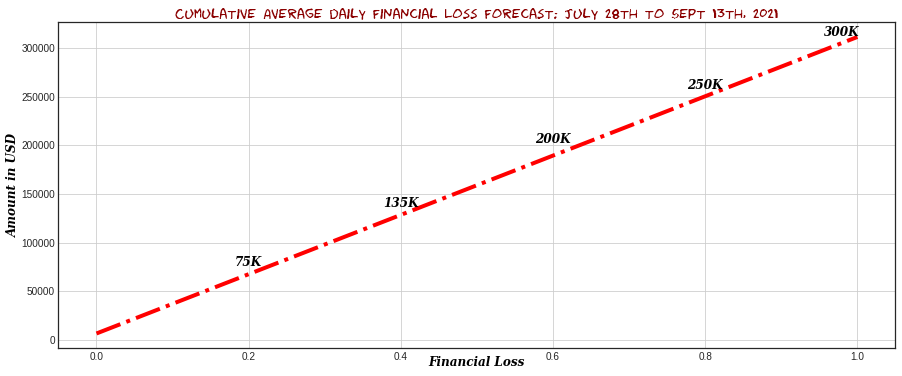

In [41]:
title = 'Cumulative Average Daily Financial Loss Forecast: July 28th to Sept 13th, 2021'
val1 = ave_daily_loss
val2 = total_loss
size = (15, 6)

plot_financial_loss_summary(val1, val2, size, title=title)

If this trend continues till the forecasted end by 13th Sept 2021, On average daily, merchants will Lose: `$6359`, with a total Financial Loss: `$311567` by 13th Sept 2021.